# NLP: Classify Articles from Titles

We will walk through an end-to-end example of taking the raw text of the articles' titles, clean it, tokenize and vectorize it, explore it, and develop a model to classify each article into one of 4 labeled classes (business, sports, technology, or entertainment). 

In [1]:
import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib default plotting styles
plt.rc("patch", edgecolor="black", force_edgecolor=True)
plt.rc("axes", grid=True)
plt.rc("grid", linestyle=":", linewidth=0.8, alpha=0.7)
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", figsize=(11, 8))
plt.rc("font", size=12.0)
plt.rc("hist", bins=25)

import acquire

## Acquire: Scrape InShorts.com

Acquire news articles from [InShorts](inshorts.com) using `BeautifulSoup` and `get.requests`

- [business](https://inshorts.com/en/read/business)
- [sports](https://inshorts.com/en/read/sports)
- [technology](https://inshorts.com/en/read/technology)
- [entertainment](https://inshorts.com/en/read/entertainment)

In [2]:
original_df = acquire.get_news_articles()

In [3]:
original_df.head()

,Unnamed: 0,author,body,category,published_date,title
0,0,Dharna,"The Delhi Police has seized over 2,000 fake Xi...",business,2019-12-07T06:30:22.000Z,Fake Xiaomi products worth ₹13 lakh seized fro...
1,1,Krishna Veera Vanamali,After a US jury found that Elon Musk did not d...,business,2019-12-07T16:34:59.000Z,My faith in humanity is restored: Musk after w...
2,2,Krishna Veera Vanamali,"British cave explorer Vernon Unsworth, who los...",business,2019-12-07T15:31:16.000Z,I'll take it on the chin: Cave explorer after ...
3,3,Krishna Veera Vanamali,SoftBank CEO Masayoshi Son has said the decisi...,business,2019-12-06T16:27:31.000Z,"We are the same animal, we are both a little c..."
4,4,Krishna Veera Vanamali,Airtel has fixed a security flaw that could ha...,business,2019-12-07T09:45:04.000Z,23-yr-old finds Airtel app bug that could have...


We are only going to work with the article titles in this example. 
We will select title and category (our target variable) and assign those to a new dataframe that we will work with moving forward. 

In [4]:
df = original_df[['title','category']]

In [5]:
df.head()

,title,category
0,Fake Xiaomi products worth ₹13 lakh seized fro...,business
1,My faith in humanity is restored: Musk after w...,business
2,I'll take it on the chin: Cave explorer after ...,business
3,"We are the same animal, we are both a little c...",business
4,23-yr-old finds Airtel app bug that could have...,business


In [6]:
df.shape

(99, 2)

## Prepare
### Normalize Text

- Convert to all lowercase  
- Normalize the unicode chars  
- Remove any non-alpha or whitespace characters  
- Remove any alpha strings with 2 characters or less  

In [7]:
string = df.title[0]
print(string)
string = string.lower()
print(string)
string = unicodedata.normalize('NFKD', string).encode('ascii', 'ignore').decode('utf-8', 'ignore')
print(string)

string = re.sub(r'[^a-z]', ' ', string)
print(string)

string = re.sub(r'\b[a-z]{,2}\b', '', string)
print(string)

string = re.sub(r'[\r|\n|\r\n]+', ' ', string)
print(string)

string = re.sub(r'\s+', ' ', string)
print(string)

string = string.strip()
print(string)

Fake Xiaomi products worth ₹13 lakh seized from Delhi's Gaffar Market
fake xiaomi products worth ₹13 lakh seized from delhi's gaffar market
fake xiaomi products worth 13 lakh seized from delhi's gaffar market
fake xiaomi products worth    lakh seized from delhi s gaffar market
fake xiaomi products worth    lakh seized from delhi  gaffar market
fake xiaomi products worth    lakh seized from delhi  gaffar market
fake xiaomi products worth lakh seized from delhi gaffar market
fake xiaomi products worth lakh seized from delhi gaffar market


In [8]:
def normalize(string):
    """
    Convert to all lowercase  
    Normalize the unicode chars  
    Remove any non-alpha or whitespace characters  
    Remove any alpha strings with 2 characters or less  
    """
    string = string.lower()
    string = unicodedata.normalize('NFKD', string).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # keep only alpha chars
    string = re.sub(r'[^a-z]', ' ', string)
    
    # remove strings less than 2 chars in length
    string = re.sub(r'\b[a-z]{,2}\b', '', string)
    
    # convert newlines and tabs to a single space
    string = re.sub(r'[\r|\n|\r\n]+', ' ', string)
    
    # strip extra whitespace
    string = string.strip()
    
    return string

df = df.assign(normalized = df.title.apply(normalize))

### Stem

In [9]:
print(string)

ps = nltk.porter.PorterStemmer()
stems = [ps.stem(word) for word in string.split()]
stem_string = ' '.join(stems)

fake xiaomi products worth lakh seized from delhi gaffar market


In [10]:
def stem(string):
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in string.split()]
    string_of_stems = ' '.join(stems)
    return string_of_stems

### Lemmatize

In [11]:
print(string)
wnl = nltk.stem.WordNetLemmatizer()
lemmas = [wnl.lemmatize(word) for word in string.split()]
lemma_string = ' '.join(lemmas)
print(lemma_string)
print(stem_string)

fake xiaomi products worth lakh seized from delhi gaffar market
fake xiaomi product worth lakh seized from delhi gaffar market
fake xiaomi product worth lakh seiz from delhi gaffar market


In [12]:
def lemmatize(string):
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    string_of_lemmas = ' '.join(lemmas)
    return string_of_lemmas

### Tokenize

In [13]:
print(string)
tokenizer = nltk.tokenize.ToktokTokenizer()
tokenized_string = tokenizer.tokenize(string, return_str=True)

fake xiaomi products worth lakh seized from delhi gaffar market


In [14]:
def tokenize(string):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    return tokenizer.tokenize(string, return_str=True)

### Remove Stopwords

In [15]:
words = tokenized_string.split()
print(words)
stopwords_list = stopwords.words('english')
exclude_words = ['me']
stopwords_list = set(stopwords_list) - set(exclude_words)
include_words = ['Dom']
stopwords_list = stopwords_list.union(set(include_words))
filtered_words = [w for w in words if w not in stopwords_list]
filtered_words = ' '.join(filtered_words)
filtered_words

['fake', 'xiaomi', 'products', 'worth', 'lakh', 'seized', 'from', 'delhi', 'gaffar', 'market']


'fake xiaomi products worth lakh seized delhi gaffar market'

In [16]:
def remove_stopwords(tokenized_string, extra_words=[], exclude_words=[]):
    words = tokenized_string.split()
    stopword_list = stopwords.words('english')

    # remove the excluded words from the stopword list
    stopword_list = set(stopword_list) - set(exclude_words)

    # add in the user specified extra words
    stopword_list = stopword_list.union(set(extra_words))

    filtered_words = [w for w in words if w not in stopword_list]
    final_string = " ".join(filtered_words)
    return final_string

### Prep Summary

In [17]:
df = original_df[['title','category']]
df.head()

,title,category
0,Fake Xiaomi products worth ₹13 lakh seized fro...,business
1,My faith in humanity is restored: Musk after w...,business
2,I'll take it on the chin: Cave explorer after ...,business
3,"We are the same animal, we are both a little c...",business
4,23-yr-old finds Airtel app bug that could have...,business


In [18]:
df = original_df[['title','category']]
df = df.assign(original = df.title)

df = df.assign(normalized = df.original.apply(normalize))

df = df.assign(stemmed = df.normalized.apply(stem))
df = df.assign(lemmatized = df.normalized.apply(lemmatize))

df = df.assign(cleaned = df.stemmed.apply(remove_stopwords))
df.head()

,title,category,original,normalized,stemmed,lemmatized,cleaned
0,Fake Xiaomi products worth ₹13 lakh seized fro...,business,Fake Xiaomi products worth ₹13 lakh seized fro...,fake xiaomi products worth lakh seized from...,fake xiaomi product worth lakh seiz from delhi...,fake xiaomi product worth lakh seized from del...,fake xiaomi product worth lakh seiz delhi gaff...
1,My faith in humanity is restored: Musk after w...,business,My faith in humanity is restored: Musk after w...,faith humanity restored musk after winning ...,faith human restor musk after win defam case,faith humanity restored musk after winning def...,faith human restor musk win defam case
2,I'll take it on the chin: Cave explorer after ...,business,I'll take it on the chin: Cave explorer after ...,take the chin cave explorer after losing ca...,take the chin cave explor after lose case agai...,take the chin cave explorer after losing case ...,take chin cave explor lose case elon musk
3,"We are the same animal, we are both a little c...",business,"We are the same animal, we are both a little c...",are the same animal are both little crazy ...,are the same anim are both littl crazi masayos...,are the same animal are both little crazy masa...,anim littl crazi masayoshi son jack
4,23-yr-old finds Airtel app bug that could have...,business,23-yr-old finds Airtel app bug that could have...,old finds airtel app bug that could have expos...,old find airtel app bug that could have expos ...,old find airtel app bug that could have expose...,old find airtel app bug could expos data crore...


In [19]:
def prep_articles(df):
    df = df.assign(original = df.title)
    df = df.assign(normalized = df.original.apply(normalize))
    df = df.assign(stemmed = df.normalized.apply(stem))
    df = df.assign(lemmatized = df.normalized.apply(lemmatize))
    df = df.assign(cleaned = df.stemmed.apply(remove_stopwords))
    df.drop(columns=["title"], inplace=True)
    return df

### Wrangle Summary (Acquire + Prep)

1. acquire data via web scraping  
2. select the column of text to be used as features and the target variable  
3. prepare the text  
    - normalize the text  
    - lemmatize the normalized text  
    - remove stopwords from the lemmatized text  
    

In [20]:
def prep_news_articles(text, target):
    df = acquire.get_news_articles()
    df = df[[text, target]]
    df = prep_articles(df)
    return df

In [21]:
df = prep_news_articles('title','category')

In [22]:
df = df[['category','cleaned']]

df.head()

,category,cleaned
0,business,fake xiaomi product worth lakh seiz delhi gaff...
1,business,faith human restor musk win defam case
2,business,take chin cave explor lose case elon musk
3,business,anim littl crazi masayoshi son jack
4,business,old find airtel app bug could expos data crore...


## Explore & Define Features

We will do a very quick exploration, due to time, which will naturally blend into feature engineering.  

### Category Distribution

In [23]:
df.category.value_counts(normalize=True)

sports           0.252525
technology       0.252525
entertainment    0.252525
business         0.242424
Name: category, dtype: float64

In [24]:
pd.concat(
    [df.category.value_counts(), df.category.value_counts(normalize=True)], axis=1
).set_axis(["n", "percent"], axis=1, inplace=False)

,n,percent
sports,25,0.252525
technology,25,0.252525
entertainment,25,0.252525
business,24,0.242424


### Term Frequency

Generally, when you hear 'Term Frequency', it is referring to the number of documents in which a word appears.  
*When we move on to computing TF-IDF, this basic definition of Term Frequency applies*.  

However, term frequency can be calculated in a number of ways, all of which reflect how frequently a word appears in a document.  

- **Raw Count**: This is simply the count of the number of occurances of each word.
- **Frequency**: The number of times each word appears divided by the total number of words.
- **Augmented Frequency**: The frequency of each word divided by the maximum frequency. This can help prevent bias towards larger documents.

One way I will use term frequency here is to remove any term from the documents if that term frequency is 1. There is no value and will likely lead to overfitting when the term only appears in 1 article.

In [25]:
raw_count = pd.Series(" ".join(df.cleaned).split()).value_counts()

Text(0.5, 1.0, '10 most common words')

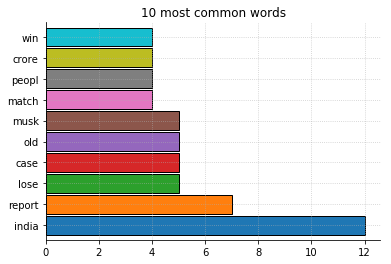

In [26]:
raw_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('10 most common words')

In [27]:
raw_count.index

Index(['india', 'report', 'lose', 'case', 'old', 'musk', 'take', 'singh',
       'user', 'film',
       ...
       'khan', 'ayushmann', 'import', 'season', 'nba', 'athlet', 'speak',
       'kabir', 'year', 'yuvraj'],
      dtype='object', length=574)

In [28]:
tf_df = pd.DataFrame({'word': raw_count.index, 'raw_count': raw_count}).set_index('word')
tf_df = tf_df[tf_df.raw_count > 1]
tf_df = tf_df.assign(tf=lambda df: df.raw_count / df.raw_count.sum())\
    .assign(augmented_frequency=lambda df: df.tf / df.tf.max())

tf_df.head(6)

,raw_count,tf,augmented_frequency
word,,,
india,12,0.036474,1.000000
report,7,0.021277,0.583333
lose,5,0.015198,0.416667
case,5,0.015198,0.416667
old,5,0.015198,0.416667
musk,5,0.015198,0.416667


### Inverse Document Frequency (IDF)

Inverse Document Frequency also provides information about individual words, but, in order to use this measure, we must have multiple documents, i.e. several different bodies of text.

- provides information about individual words in a document with respect the those words' frequency across the corpus, which must include multiple documents.  
- indicates how valuable a word is in terms of the information it provides.
- The more frequently a word appears in the corpus, the less information it provides when found in a certain document. This will lead to a lower IDF score. 
- Lower IDF $\rightarrow$ less important when found in a document, i.e. that word gives us less information about the document than a word with a high IDF. 
- Example: 'the' would have a *very* low IDF which indicates we learn very little about an individual document knowing that the word 'the' appears in it.  

$$
\mbox{idf}(\mbox{word})
=
\log\left(\frac{\mbox{# of documents}}{\mbox{# of documents containing the word + 1}}\right)
$$

Notes on IDF calculation

- If a given word doesn't appear in any documents, the denominator in the equation above would be zero, so it is best to add 1 to the denominator, as indicated above.   
- The denominator is *NOT* necessarily equivalent to Term Frequency, which is the total number of times the word appears in a corpus. When a word appears in a document more than once, these numbers will differ. 

Compute IDF for the titles of the news ariticles. We need:  

- number of occurrences of the word (denominator)   
- total number of documents (numerator) 

First, let's compute IDF for a single word to see how it's done.  

In [29]:
print("word: india")
denom = sum([1 for doc in df.cleaned if 'india' in doc])
print("# of occurrences: ", denom)
num = len(df.cleaned)
print("# of documents: ", num)
idf = np.log(num/(denom+1))
print("idf = ", idf)

word: india
# of occurrences:  13
# of documents:  99
idf =  1.9560625205193314


Write the IDF function

In [30]:
def idf(word):
    n_occurrences = sum([1 for doc in df.cleaned if word in doc])
    n_docs = len(df.cleaned)
    idf = np.log(n_docs/n_occurrences)
    return idf

Now, we need to do it for all words in our corpus. To do that, we need:  

- list of unique words  
- remove the words with a count of only 1 (stored in tf_df
- assign words to a dataframe  
- calculate the idf for each word  

#### Unique Words

- join all docs together into corpus as single document
- split corpus into single words & convert to list of words
- keep only a single, unique value for each word. (dedup)


In [31]:
unique_words = pd.Series(' '.join(df.cleaned).split()).unique()

In [32]:
# keep only words whose frequency is > 1
unique_words = list(set(unique_words).intersection(set(tf_df.index)))

- add to a dataframe
- apply idf() to compute IDF for each unique word
- sort idf_df for quick peeks into the results

In [33]:
tf_df.head()

,raw_count,tf,augmented_frequency
word,,,
india,12,0.036474,1.000000
report,7,0.021277,0.583333
lose,5,0.015198,0.416667
case,5,0.015198,0.416667
old,5,0.015198,0.416667


In [34]:
# put in a dataframe
idf_df = pd.DataFrame(dict(word = unique_words))\
    .assign(idf = lambda df: df.word.apply(idf))\
    .set_index('word').sort_values(by='idf', ascending = False)

tfidf_df = idf_df.join(tf_df)

### TF-IDF

In [35]:
# We'll caclulate the tf-idf value for every word across every document
tfs = []

documents = dict(df.cleaned)
for doc, text in documents.items():
    tf_df = pd.Series(text.split())

# documents.items()
tf_df.reset_index()

# .set_axis(['index','word'])

,index,0
0,0,rakul
1,1,star
2,2,alongsid
3,3,ajay
4,4,indra
5,5,kumar
6,6,film
7,7,report


In [36]:
# Start by iterating over all the documents
for doc, text in documents.items():
    # We'll make a data frame that contains the tf for every word in every document
    tf_df = (pd.Series(text.split())
          .value_counts()
          .reset_index()
          .set_axis(['word', 'raw_count'], axis=1, inplace=False)
          .assign(tf=lambda df: df.raw_count / df.shape[0])
          .drop(columns='raw_count')
          .assign(doc=doc))
    # Then add that data frame to our list
    tfs.append(tf_df)

In [37]:
tfs[0:2]

[      word        tf  doc
 0  product  0.111111    0
 1   gaffar  0.111111    0
 2   market  0.111111    0
 3     lakh  0.111111    0
 4     fake  0.111111    0
 5   xiaomi  0.111111    0
 6     seiz  0.111111    0
 7    worth  0.111111    0
 8    delhi  0.111111    0,      word        tf  doc
 0     win  0.142857    1
 1  restor  0.142857    1
 2    musk  0.142857    1
 3   human  0.142857    1
 4    case  0.142857    1
 5   faith  0.142857    1
 6   defam  0.142857    1]

In [38]:
tfidf_df = pd.concat(tfs)\
            .assign(idf = lambda tf_df: tf_df.word.apply(idf))\
            .assign(tf_idf = lambda tf_df: tf_df.idf * tf_df.tf)\
            .drop(columns=['tf', 'idf'])\
            .sort_values(by='tf_idf', ascending=False)

In [39]:
tfidf_df.head()

,word,doc,tf_idf
0,game,44,1.531707
0,industri,5,1.148780
0,call,49,1.114849
0,onion,8,0.919024
1,bengaluru,8,0.919024


In [40]:
# look at importances based on tf_idf values

tfidf_df.sort_values('tf_idf', ascending = False)
reduced_df = tfidf_df[tfidf_df.tf_idf > .75]
reduced_df

,word,doc,tf_idf
0,game,44,1.531707
0,industri,5,1.148780
0,call,49,1.114849
0,onion,8,0.919024
1,bengaluru,8,0.919024
2,surg,8,0.919024
0,women,94,0.874127
3,price,8,0.780395
5,slab,11,0.765853
0,watchdog,63,0.765853


### TF-IDF with Scikit-Learn

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidfs = tfidf.fit_transform(documents.values())

This returns a sparse matrix:  
- a matrix with more 0s than anything else. 
- Numpy has a special type that makes some manipulations and operations faster on sparse matrices.

Becuase our data set is pretty small, we can convert our sparse matrix to a regular one, aka 'dense matrix', and put everything in a dataframe. If our data were larger, the operation below might take much longer.

In [42]:
features_df = pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())
features_df.head()

,acceler,account,acquir,across,action,actor,actress,age,agre,air,...,wrong,xiaomi,yard,year,yet,yohan,youtub,yr,yuvraj,zilingo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.342884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
reduced_df[['word', 'tf_idf']].set_index('word').T

word,game,industri,call,onion,bengaluru,surg,women,price,slab,watchdog,...,father,catherin,wife,law,srk,metoo,untouch,littl,somebodi,probe
tf_idf,1.531707,1.14878,1.114849,0.919024,0.919024,0.919024,0.874127,0.780395,0.765853,0.765853,...,0.765853,0.765853,0.765853,0.765853,0.765853,0.765853,0.765853,0.765853,0.765853,0.765853


## Modeling

In [44]:
df = prep_news_articles('title','category')
df.head()

,category,original,normalized,stemmed,lemmatized,cleaned
0,business,Fake Xiaomi products worth ₹13 lakh seized fro...,fake xiaomi products worth lakh seized from...,fake xiaomi product worth lakh seiz from delhi...,fake xiaomi product worth lakh seized from del...,fake xiaomi product worth lakh seiz delhi gaff...
1,business,My faith in humanity is restored: Musk after w...,faith humanity restored musk after winning ...,faith human restor musk after win defam case,faith humanity restored musk after winning def...,faith human restor musk win defam case
2,business,I'll take it on the chin: Cave explorer after ...,take the chin cave explorer after losing ca...,take the chin cave explor after lose case agai...,take the chin cave explorer after losing case ...,take chin cave explor lose case elon musk
3,business,"We are the same animal, we are both a little c...",are the same animal are both little crazy ...,are the same anim are both littl crazi masayos...,are the same animal are both little crazy masa...,anim littl crazi masayoshi son jack
4,business,23-yr-old finds Airtel app bug that could have...,old finds airtel app bug that could have expos...,old find airtel app bug that could have expos ...,old find airtel app bug that could have expose...,old find airtel app bug could expos data crore...


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.cleaned)
y = df.category

In [46]:
y.head()

0    business
1    business
2    business
3    business
4    business
Name: category, dtype: object

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

In [48]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

In [49]:
dt = DecisionTreeClassifier(criterion='entropy', splitter='best', 
                            max_depth=5, min_samples_split=2,
                           min_samples_leaf=1, random_state=123)\
            .fit(X_train, y_train)

In [50]:
train['predicted'] = dt.predict(X_train)
test['predicted'] = dt.predict(X_test)

In [51]:
test.head()

,actual,predicted
85,entertainment,sports
81,entertainment,sports
49,technology,sports
52,technology,business
7,business,sports


In [52]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 41.77%
---
Confusion Matrix
actual         business  entertainment  sports  technology
predicted                                                 
business              3              0       0           0
entertainment         0              4       0           0
sports               15             16      20          14
technology            1              0       0           6
---
               precision    recall  f1-score   support

     business       1.00      0.16      0.27        19
entertainment       1.00      0.20      0.33        20
       sports       0.31      1.00      0.47        20
   technology       0.86      0.30      0.44        20

    micro avg       0.42      0.42      0.42        79
    macro avg       0.79      0.41      0.38        79
 weighted avg       0.79      0.42      0.38        79



In [53]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 25.00%
---
Confusion Matrix
actual     business  entertainment  sports  technology
predicted                                             
business          0              0       0           2
sports            5              5       5           3
---
               precision    recall  f1-score   support

     business       0.00      0.00      0.00         5
entertainment       0.00      0.00      0.00         5
       sports       0.28      1.00      0.43         5
   technology       0.00      0.00      0.00         5

    micro avg       0.25      0.25      0.25        20
    macro avg       0.07      0.25      0.11        20
 weighted avg       0.07      0.25      0.11        20



/Users/maggiegiust/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [54]:
svc = SVC(probability=True)
svc = svc.fit(X_train, y_train)

train['predicted'] = svc.predict(X_train)
test['predicted'] = svc.predict(X_test)

/Users/maggiegiust/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [55]:
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

---
Confusion Matrix
actual         business  entertainment  sports  technology
predicted                                                 
entertainment         2             20       0           0
sports                2              0      20           0
technology           15              0       0          20
---
               precision    recall  f1-score   support

     business       0.00      0.00      0.00        19
entertainment       0.91      1.00      0.95        20
       sports       0.91      1.00      0.95        20
   technology       0.57      1.00      0.73        20

    micro avg       0.76      0.76      0.76        79
    macro avg       0.60      0.75      0.66        79
 weighted avg       0.60      0.76      0.67        79



In [56]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 50.00%
---
Confusion Matrix
actual         business  entertainment  sports  technology
predicted                                                 
entertainment         0              1       0           1
sports                2              0       5           0
technology            3              4       0           4
---
               precision    recall  f1-score   support

     business       0.00      0.00      0.00         5
entertainment       0.50      0.20      0.29         5
       sports       0.71      1.00      0.83         5
   technology       0.36      0.80      0.50         5

    micro avg       0.50      0.50      0.50        20
    macro avg       0.39      0.50      0.40        20
 weighted avg       0.39      0.50      0.40        20



In [57]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble.forest:

class RandomForestClassifier(ForestClassifier)
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is always the same as the original
 |  input sample size but the samples are drawn with replacement if
 |  `bootstrap=True` (default).
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimators : integer, optional (default=10)
 |      The number of trees in the forest.
 |  
 |      .. versionchanged:: 0.20
 |         The default value of ``n_estimators`` will change from 10 in
 |         version 0.20 to 100 in version 0.22.
 |  
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria 

In [58]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 3, min_samples_split=5)
rf = rf.fit(X_train, y_train)

train['predicted'] = rf.predict(X_train)
test['predicted'] = rf.predict(X_test)

In [59]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 94.94%
---
Confusion Matrix
actual         business  entertainment  sports  technology
predicted                                                 
business             16              0       0           0
entertainment         1             20       0           0
sports                1              0      19           0
technology            1              0       1          20
---
               precision    recall  f1-score   support

     business       1.00      0.84      0.91        19
entertainment       0.95      1.00      0.98        20
       sports       0.95      0.95      0.95        20
   technology       0.91      1.00      0.95        20

    micro avg       0.95      0.95      0.95        79
    macro avg       0.95      0.95      0.95        79
 weighted avg       0.95      0.95      0.95        79



In [60]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 30.00%
---
Confusion Matrix
actual         business  entertainment  sports  technology
predicted                                                 
business              0              0       0           2
entertainment         1              1       0           1
sports                1              0       3           0
technology            3              4       2           2
---
               precision    recall  f1-score   support

     business       0.00      0.00      0.00         5
entertainment       0.33      0.20      0.25         5
       sports       0.75      0.60      0.67         5
   technology       0.18      0.40      0.25         5

    micro avg       0.30      0.30      0.30        20
    macro avg       0.32      0.30      0.29        20
 weighted avg       0.32      0.30      0.29        20



In [61]:
pd.Series(dict(zip(tfidf.get_feature_names(), rf.feature_importances_))).sort_values().tail(100)

know        0.003648
vietnam     0.003650
titl        0.003661
thrash      0.003662
model       0.003687
googl       0.003688
teammat     0.003701
map         0.003734
hour        0.003744
csa         0.003747
musk        0.003759
lionel      0.003775
resolv      0.003799
vijay       0.003812
big         0.003813
gcx         0.003844
postpon     0.003882
catch       0.003883
hacker      0.003892
go          0.003911
singh       0.003918
good        0.003945
wood        0.003958
war         0.003959
kid         0.004000
across      0.004004
decemb      0.004065
dribbl      0.004078
human       0.004148
issu        0.004154
              ...   
kevin       0.006747
befor       0.006775
harass      0.007016
au          0.007227
indi        0.007461
site        0.007740
cancer      0.007810
old         0.007862
first       0.008076
kamal       0.008152
airtel      0.008472
wa          0.008565
pak         0.009519
take        0.009736
month       0.009864
lose        0.010421
test        0

In [62]:
rf.feature_importances_
tfidf.get_feature_names()

['acceler',
 'account',
 'acquir',
 'across',
 'action',
 'actor',
 'actress',
 'age',
 'agre',
 'air',
 'airport',
 'airtel',
 'ajay',
 'alia',
 'alongsid',
 'also',
 'analytica',
 'ananya',
 'anderson',
 'anim',
 'ankiti',
 'app',
 'appl',
 'arjun',
 'around',
 'associ',
 'athlet',
 'attempt',
 'au',
 'auto',
 'avail',
 'ayushmann',
 'back',
 'bad',
 'bairstow',
 'bajaj',
 'balakot',
 'ball',
 'ban',
 'bank',
 'banker',
 'battl',
 'bcci',
 'beast',
 'beat',
 'becom',
 'bed',
 'befor',
 'bengaluru',
 'best',
 'bharti',
 'big',
 'bikini',
 'birla',
 'black',
 'blake',
 'bmw',
 'board',
 'bodi',
 'boe',
 'bose',
 'bowl',
 'break',
 'breast',
 'budget',
 'bug',
 'burn',
 'burnley',
 'cabl',
 'call',
 'cambridg',
 'campaign',
 'cancer',
 'carolin',
 'case',
 'catch',
 'catherin',
 'cave',
 'celebr',
 'ceo',
 'certif',
 'chang',
 'charg',
 'chest',
 'chhalaang',
 'chin',
 'china',
 'chiranjeevi',
 'choic',
 'cloud',
 'coai',
 'come',
 'commentari',
 'commun',
 'compani',
 'compon',
 'confi